We use an approach `A(orig)` -> `Q(llm)` -> `A(llm)` to calculate cosine similarity between `A(orig)` and `A(llm)`.

## Load documents with IDs

In [1]:
import requests

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/documents-with-ids.json'
docs_url = f'{base_url}/{relative_url}?raw=1'

docs_response = requests.get(docs_url)
documents = docs_response.json()

In [2]:
with open("/workspaces/llm-zoomcamp/04-monitoring/documents-with-ids.json", "w") as file:
  file.write(docs_response.text)

In [3]:
documents[:2]

[{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
  'section': 'General course-related questions',
  'question': 'Course - When will the course start?',
  'course': 'data-engineering-zoomcamp',
  'id': 'c02e79ef'},
 {'text': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites',
  'section': 'General course-related questions',
  'question': 'Course - What are the prerequisites for this course?',
  'course': 'data-engineering-zoomcamp',
  'id': '1f6520ca'}]

## Load ground truth

In [4]:
base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/ground-truth-data.csv'
ground_truth_url = f'{base_url}/{relative_url}?raw=1'

In [5]:
ground_truth_response = requests.get(ground_truth_url)
with open("/workspaces/llm-zoomcamp/04-monitoring/ground-truth-data.csv", "w") as file:
  file.write(ground_truth_response.text)

In [6]:
import pandas as pd

df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth_filtered = df_ground_truth[df_ground_truth.course == "machine-learning-zoomcamp"]
ground_truth = df_ground_truth.to_dict(orient='records')

In [7]:
ground_truth[:2]

[{'question': 'When does the course begin?',
  'course': 'data-engineering-zoomcamp',
  'document': 'c02e79ef'},
 {'question': 'How can I get the course schedule?',
  'course': 'data-engineering-zoomcamp',
  'document': 'c02e79ef'}]

In [147]:
documents_dictionary = { doc["id"]: doc for doc in documents }
documents_dictionary["c02e79ef"]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp',
 'id': 'c02e79ef',
 'question_text_vector': array([-2.47415043e-02,  1.25250854e-02,  1.86790284e-02, -2.44591571e-03,
        -6.29659519e-02, -1.47208141e-03, -9.39881057e-02, -7.70688802e-02,
        -2.42589451e-02, -2.65894621e-03, -3.13756466e-02,  2.58985404e-02,
         1.27616717e-04,  1.16563798e-03,  5.24653681e-03, -2.75482610e-02,
         1.25110541e-02, -1.4804229

In [9]:
documents_dictionary["886d1617"]["text"]

'Problem description\nInfrastructure created in AWS with CD-Deploy Action needs to be destroyed\nSolution description\nFrom local:\nterraform init -backend-config="key=mlops-zoomcamp-prod.tfstate" --reconfigure\nterraform destroy --var-file vars/prod.tfvars\nAdded by Erick Calderin'

## Index data

In [10]:
from sentence_transformers import SentenceTransformer

# https://sbert.net/docs/sentence_transformer/pretrained_models.html
embedding_model_name = "multi-qa-MiniLM-L6-cos-v1"
embedding_model = SentenceTransformer(embedding_model_name)

/home/jovyan/.local/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [11]:
user_question = "I just discovered the course. Can I still join it?"
user_question_embedding = embedding_model.encode(user_question)

embedding_dimension = len(user_question_embedding)
embedding_dimension

384

In [12]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch("http://elasticsearch:9200")

In [13]:
es_client.info()

ObjectApiResponse({'name': '18aea8f7636a', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'rh8W2g-VTG2xai6LlbhWGg', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [14]:
index_name = "questions"

index_settings = {
    "settings": {"number_of_shards": 1, "number_of_replicas": 0},
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": { # Note that the name comes from the name of the document's field (see below)
                "type": "dense_vector",
                "dims": embedding_dimension,
                "index": True,
                "similarity": "cosine",
            },
        }
    },
}

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'questions'})

In [15]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    question = doc["question"]
    text = doc["text"]
    doc["question_text_vector"] = embedding_model.encode(f"{question} {text}")

    es_client.index(index=index_name, document=doc)

  0%|          | 0/948 [00:00<?, ?it/s]

100%|██████████| 948/948 [00:41<00:00, 22.88it/s]


## Retrieval

In [16]:
def elastic_search_knn(field: str, vector: str, course: str, result_number=5):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": result_number,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(index=index_name, body=search_query)

    result_docs = []

    for hit in es_results["hits"]["hits"]:
        result_docs.append(hit["_source"])
    
    return result_docs

In [17]:
def question_text_vector_knn(question: dict, result_number=5):
    question_text = question["question"]
    course = question["course"]

    question_vector = embedding_model.encode(question_text)

    return elastic_search_knn("question_text_vector", question_vector, course, result_number)

In [18]:
search_result = question_text_vector_knn(
    dict(
        question="Are sessions recorded if I miss one?",
        course="machine-learning-zoomcamp",
    )
)

search_result

[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'id': '39fda9f0'},
 {'question': 'The same accuracy on epochs',
  'course': 'machine-learning-zoomcamp',
  'section': '8. Neural Networks an

In [19]:
search_result = question_text_vector_knn(
    dict(
        question="Where can I download a recorded session?",
        course="machine-learning-zoomcamp",
    ), result_number=2
)

search_result

[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'id': '39fda9f0'}]

## The RAG flow

In [20]:
def build_prompt(query, search_results):
    prompt_template = (
        "You're a course teaching assistant. Answer the QUESTION based on "
        "the CONTEXT from the FAQ database. "
        "Use only the facts from the CONTEXT when answering the QUESTION. "
        "QUESTION: {question} "
        "CONTEXT: {context}"
    ).strip()

    context = ""

    for doc in search_results:
        context = (
            context
            + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
        )

    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [21]:
import json
import boto3


session = boto3.Session(profile_name="private")
bedrock_runtime = session.client("bedrock-runtime", region_name="us-east-1")

def llm(prompt: str) -> str:
    # model = "amazon.titan-text-express-v1"
    model = "amazon.titan-text-premier-v1:0"
    # model = "amazon.titan-text-lite-v1"

    # input_prompt = f"User: {prompt}\nBot:"
    # input_prompt = "Make up a fixture story about a cat in the space."
    # text_generation_config = {
    #     "maxTokenCount": 1000,
    #     "stopSequences": [],
    #     "temperature": 0.9,
    #     "topP": 0.9,
    # }

    input_prompt = prompt

    text_generation_config = {
        "maxTokenCount": 1000,
        "temperature": 0.9,
    }

    kwargs = {
        "modelId": model,
        "contentType": "application/json",
        "accept": "*/*",
        "body": json.dumps(
            {
                "inputText": input_prompt,
                "textGenerationConfig": text_generation_config
            }
        ),
    }

    response = bedrock_runtime.invoke_model(**kwargs)
    body_as_plain_text = response.get("body").read()
    response_body = json.loads(body_as_plain_text)

    result = response_body["results"][0]["outputText"]

    return (result.strip())

In [22]:
def rag(query: dict) -> str:
  search_results = question_text_vector_knn(query)
  prompt = build_prompt(query["question"], search_results)
  answer = llm(prompt)

  return answer

In [23]:
ground_truth[50]

{'question': 'How many weekly hours should I dedicate to this course?',
 'course': 'data-engineering-zoomcamp',
 'document': 'ea739c65'}

In [24]:
from pprint import pprint
pprint(documents_dictionary["ea739c65"]["text"])

('It depends on your background and previous experience with modules. It is '
 'expected to require about 5 - 15 hours per week. [source1] [source2]\n'
 'You can also calculate it yourself using this data and then update this '
 'answer.')


In [25]:
answer_llm = rag(ground_truth[50])
pprint(answer_llm)

('It depends on your background and previous experience with modules. It is '
 'expected to require about 5 - 15 hours per week.')


## Cosine similarity metric

In [26]:
answer_origin = ('It depends on your background and previous experience with modules. It is '
 'expected to require about 5 - 15 hours per week. [source1] [source2]\n'
 'You can also calculate it yourself using this data and then update this '
 'answer.')

answer_llm = ('It depends on your background and previous experience with modules. It is '
 'expected to require about 5 - 15 hours per week.')

answer_origin_vector = embedding_model.encode(answer_origin)
answer_llm_vector = embedding_model.encode(answer_llm)

# cosine similarity is the product between two vectors
result = answer_origin_vector.dot(answer_llm_vector)
pprint(result)

0.93611056


In [78]:
answers = {}

In [79]:
# take first 20 items
for idx, item in tqdm(enumerate(ground_truth[:20])):
    if idx in answers:
        print(f"The document id {idx} exists in the list of answers")
        continue
    
    doc_id = item["document"]
    original_doc = documents_dictionary[doc_id]
    answer_origin = original_doc["text"]
    answer_llm = rag(item)

    answers[idx] = {
        "answer_llm": answer_llm,
        "question_llm": item["question"],
        "answer_orig": answer_origin,
        "document": doc_id
    }

20it [00:24,  1.22s/it]


In [80]:
pprint(answers)

{0: {'answer_llm': 'The course begins on 15th Jan 2024 at 17h00.',
     'answer_orig': 'The purpose of this document is to capture frequently '
                    'asked technical questions\n'
                    'The exact day and hour of the course will be 15th Jan '
                    '2024 at 17h00. The course will start with the first  '
                    "“Office Hours'' live.1\n"
                    'Subscribe to course public Google Calendar (it works from '
                    'Desktop only).\n'
                    'Register before the course starts using this link.\n'
                    'Join the course Telegram channel with announcements.\n'
                    "Don’t forget to register in DataTalks.Club's Slack and "
                    'join the channel.',
     'document': 'c02e79ef',
     'question_llm': 'When does the course begin?'},
 1: {'answer_llm': 'Subscribe to course public Google Calendar (it works from '
                   'Desktop only).',
     'answer_ori

In [81]:
df = pd.DataFrame(answers.values())

In [82]:
df

,answer_llm,question_llm,answer_orig,document
0,The course begins on 15th Jan 2024 at 17h00.,When does the course begin?,The purpose of this document is to capture fre...,c02e79ef
1,Subscribe to course public Google Calendar (it...,How can I get the course schedule?,The purpose of this document is to capture fre...,c02e79ef
2,Register before the course starts using this l...,What is the link for course registration?,The purpose of this document is to capture fre...,c02e79ef
3,Join the course Telegram channel with announce...,How can I receive course announcements?,The purpose of this document is to capture fre...,c02e79ef
4,Don’t forget to register in DataTalks.Club's S...,Where do I join the Slack channel?,The purpose of this document is to capture fre...,c02e79ef
5,GitHub - DataTalksClub data-engineering-zoomca...,Where can I find the prerequisites for this co...,GitHub - DataTalksClub data-engineering-zoomca...,1f6520ca
6,You can find them in GitHub - DataTalksClub da...,How do I check the prerequisites for this course?,GitHub - DataTalksClub data-engineering-zoomca...,1f6520ca
7,Github - DataTalksClub data-engineering-zoomca...,Where are the course prerequisites listed?,GitHub - DataTalksClub data-engineering-zoomca...,1f6520ca
8,GitHub - DataTalksClub data-engineering-zoomca...,What are the requirements for joining this cou...,GitHub - DataTalksClub data-engineering-zoomca...,1f6520ca
9,The prerequisites for the course can be found ...,Where is the list of prerequisites for the cou...,GitHub - DataTalksClub data-engineering-zoomca...,1f6520ca


In [83]:
import os

output_path='/workspaces/llm-zoomcamp/04-monitoring/answers-from-llm.csv'
df.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
    

### Extend data

We want to add more info to the collection `answers`.
Let's assume that the `answers` collection includes 1000+ answers were generated by LLM.

To save money, we need to update the collection `answers` with the values from the collection `ground_truth`.

In [84]:
answers.items()

dict_items([(0, {'answer_llm': 'The course begins on 15th Jan 2024 at 17h00.', 'question_llm': 'When does the course begin?', 'answer_orig': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.", 'document': 'c02e79ef'}), (1, {'answer_llm': 'Subscribe to course public Google Calendar (it works from Desktop only).', 'question_llm': 'How can I get the course schedule?', 'answer_orig': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hour

In [ ]:
answers_extended = [None] * len(answers)
for idx, val in tqdm(answers.items()):
    answers_extended[idx] = val.copy()
    answers_extended[idx].update(ground_truth[idx])
    
    # in the original video Alexey used "question" field.
    # It seems to me it will be better to name the field "question_llm"
    # to indicate that the questions have been generated by LLM
    del answers_extended[idx]["question"]
    
    answer_origin_vector = embedding_model.encode(answers_extended[idx]["answer_orig"])
    answer_llm_vector = embedding_model.encode(answers_extended[idx]["answer_llm"])
    answers_extended[idx]["cosine_similarity"] = answer_origin_vector.dot(answer_llm_vector)

In [145]:
pprint(answers_extended[0:2])

[{'answer_llm': 'The course begins on 15th Jan 2024 at 17h00.',
  'answer_orig': 'The purpose of this document is to capture frequently asked '
                 'technical questions\n'
                 'The exact day and hour of the course will be 15th Jan 2024 '
                 'at 17h00. The course will start with the first  “Office '
                 "Hours'' live.1\n"
                 'Subscribe to course public Google Calendar (it works from '
                 'Desktop only).\n'
                 'Register before the course starts using this link.\n'
                 'Join the course Telegram channel with announcements.\n'
                 "Don’t forget to register in DataTalks.Club's Slack and join "
                 'the channel.',
  'cosine_similarity': 0.5477259,
  'course': 'data-engineering-zoomcamp',
  'document': 'c02e79ef',
  'question_llm': 'When does the course begin?'},
 {'answer_llm': 'Subscribe to course public Google Calendar (it works from '
                'Deskto

In [88]:
pf = pd.DataFrame(answers_extended)
pf

,answer_llm,question_llm,answer_orig,document,course,cosine_similarity
0,The course begins on 15th Jan 2024 at 17h00.,When does the course begin?,The purpose of this document is to capture fre...,c02e79ef,data-engineering-zoomcamp,0.547726
1,Subscribe to course public Google Calendar (it...,How can I get the course schedule?,The purpose of this document is to capture fre...,c02e79ef,data-engineering-zoomcamp,0.434245
2,Register before the course starts using this l...,What is the link for course registration?,The purpose of this document is to capture fre...,c02e79ef,data-engineering-zoomcamp,0.515147
3,Join the course Telegram channel with announce...,How can I receive course announcements?,The purpose of this document is to capture fre...,c02e79ef,data-engineering-zoomcamp,0.699911
4,Don’t forget to register in DataTalks.Club's S...,Where do I join the Slack channel?,The purpose of this document is to capture fre...,c02e79ef,data-engineering-zoomcamp,0.496861
5,GitHub - DataTalksClub data-engineering-zoomca...,Where can I find the prerequisites for this co...,GitHub - DataTalksClub data-engineering-zoomca...,1f6520ca,data-engineering-zoomcamp,1.000000
6,You can find them in GitHub - DataTalksClub da...,How do I check the prerequisites for this course?,GitHub - DataTalksClub data-engineering-zoomca...,1f6520ca,data-engineering-zoomcamp,0.901101
7,Github - DataTalksClub data-engineering-zoomca...,Where are the course prerequisites listed?,GitHub - DataTalksClub data-engineering-zoomca...,1f6520ca,data-engineering-zoomcamp,1.000000
8,GitHub - DataTalksClub data-engineering-zoomca...,What are the requirements for joining this cou...,GitHub - DataTalksClub data-engineering-zoomca...,1f6520ca,data-engineering-zoomcamp,1.000000
9,The prerequisites for the course can be found ...,Where is the list of prerequisites for the cou...,GitHub - DataTalksClub data-engineering-zoomca...,1f6520ca,data-engineering-zoomcamp,0.862315


In [90]:
output_path='/workspaces/llm-zoomcamp/04-monitoring/answers-from-llm-extended.csv'
pf.to_csv(output_path, index=False)

## Calculate cosine similarity with course's data

### GPT 4o

In [107]:
csv_path_chat_gpt_4o = "/workspaces/llm-zoomcamp/04-monitoring/course_data/results-gpt4o.csv"
df_chat_gpt_4o = pd.read_csv(csv_path_chat_gpt_4o)

In [108]:
df_chat_gpt_4o

,answer_llm,answer_orig,document,question,course
0,The CONTEXT provided does not give specific in...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,You can sign up for the Machine Learning Zoomc...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,"No, the provided context does not include any ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp
...,...,...,...,...,...
1825,Some suggested titles for listing the Machine ...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,What are some suggested titles for listing the...,machine-learning-zoomcamp
1826,It is not advised to list your Machine Learnin...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,Should I list the Machine Learning Zoomcamp ex...,machine-learning-zoomcamp
1827,You can incorporate your Machine Learning Zoom...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,In which LinkedIn sections can I incorporate m...,machine-learning-zoomcamp
1828,Ani Mkrtumyan provided the advice on including...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,Who gave advice on including a project link in...,machine-learning-zoomcamp


In [109]:
results_chat_gpt_4o = df_chat_gpt_4o.to_dict(orient="records")
pprint(results_chat_gpt_4o[0:2])

[{'answer_llm': 'The CONTEXT provided does not give specific instructions on '
                'how to sign up for the course. However, it does mention that '
                'you can access the course materials on the course page: [ML '
                'Zoomcamp](http://mlzoomcamp.com/). \n'
                '\n'
                'You might want to start by visiting the course website and '
                'looking for further instructions there, as it likely has '
                'additional details on how to sign up or enroll in the course.',
  'answer_orig': 'Machine Learning Zoomcamp FAQ\n'
                 'The purpose of this document is to capture frequently asked '
                 'technical questions.\n'
                 'We did this for our data engineering course and it worked '
                 'quite well. Check this document for inspiration on how to '
                 'structure your questions and answers:\n'
                 'Data Engineering Zoomcamp FAQ\n'
           

In [110]:
answer_origin_vector = embedding_model.encode(results_chat_gpt_4o[0]["answer_orig"])
answer_llm_vector = embedding_model.encode(results_chat_gpt_4o[0]["answer_llm"])
cosine_result_chat_gpt_4o = answer_llm_vector.dot(answer_origin_vector)
cosine_result_chat_gpt_4o

0.53453267

In [112]:
def compute_similarity(item):
    answer_origin_vector = embedding_model.encode(item["answer_orig"])
    answer_llm_vector = embedding_model.encode(item["answer_llm"])
    return answer_llm_vector.dot(answer_origin_vector)

In [113]:
similarity_chat_gpt_4o_results = []

for item in tqdm(results_chat_gpt_4o):
    result = compute_similarity(item)
    similarity_chat_gpt_4o_results.append(result)

100%|██████████| 1830/1830 [01:57<00:00, 15.54it/s]


In [144]:
pprint(similarity_chat_gpt_4o_results[0:2])

[0.53453267, 0.69612145]


In [117]:
# Add a new column to the data frame
df_chat_gpt_4o["cosine"] = similarity_chat_gpt_4o_results
df_chat_gpt_4o

,answer_llm,answer_orig,document,question,course,cosine
0,The CONTEXT provided does not give specific in...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp,0.534533
1,You can sign up for the Machine Learning Zoomc...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp,0.696121
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp,0.717514
3,"No, the provided context does not include any ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp,-0.000328
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp,0.387620
...,...,...,...,...,...,...
1825,Some suggested titles for listing the Machine ...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,What are some suggested titles for listing the...,machine-learning-zoomcamp,0.789918
1826,It is not advised to list your Machine Learnin...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,Should I list the Machine Learning Zoomcamp ex...,machine-learning-zoomcamp,0.781627
1827,You can incorporate your Machine Learning Zoom...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,In which LinkedIn sections can I incorporate m...,machine-learning-zoomcamp,0.772360
1828,Ani Mkrtumyan provided the advice on including...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,Who gave advice on including a project link in...,machine-learning-zoomcamp,0.337837


In [124]:
# Let's take a look at the negative answer
pprint(df_chat_gpt_4o.iloc[3].to_dict())

{'answer_llm': 'No, the provided context does not include any information '
               'about a GitHub repository specifically for the sign-up link '
               'for the course. The context mentions various other details '
               'about GitHub usage in the course like making repositories '
               'public, creating personal repositories for notes and homework, '
               'and pushing code to GitHub, but it does not mention a GitHub '
               'repository for signing up for the course.',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\n'
                'The purpose of this document is to capture frequently asked '
                'technical questions.\n'
                'We did this for our data engineering course and it worked '
                'quite well. Check this document for inspiration on how to '
                'structure your questions and answers:\n'
                'Data Engineering Zoomcamp FAQ\n'
                'In the course GitHub rep

In [125]:
df_chat_gpt_4o["cosine"].describe()

count    1830.000000
mean        0.679129
std         0.217995
min        -0.153426
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995339
Name: cosine, dtype: float64

The `mean` describes how good the system is in general.

In [ ]:
!pip install seaborn

<Axes: xlabel='cosine', ylabel='Count'>

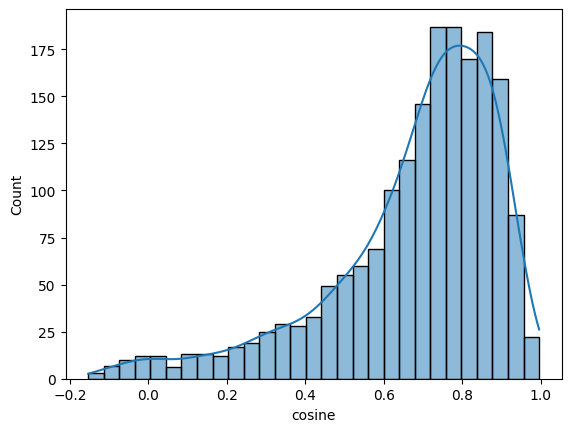

In [130]:
import seaborn as sns

# The function support the kernel density estimate line, by passing kde=True
sns.histplot(df_chat_gpt_4o["cosine"], kde=True)


### Chat GPT 3.5 Turbo

In [132]:
csv_path_chat_gpt_35_turbo = "/workspaces/llm-zoomcamp/04-monitoring/course_data/results-gpt35.csv"
df_chat_gpt_35_turbo = pd.read_csv(csv_path_chat_gpt_35_turbo)

results_chat_gpt_35_turbo = df_chat_gpt_35_turbo.to_dict(orient="records")
pprint(results_chat_gpt_35_turbo[0:2])

[{'answer_llm': 'You can sign up for the course by going to the course page at '
                'http://mlzoomcamp.com/ and scrolling down to access the '
                'course materials.',
  'answer_orig': 'Machine Learning Zoomcamp FAQ\n'
                 'The purpose of this document is to capture frequently asked '
                 'technical questions.\n'
                 'We did this for our data engineering course and it worked '
                 'quite well. Check this document for inspiration on how to '
                 'structure your questions and answers:\n'
                 'Data Engineering Zoomcamp FAQ\n'
                 'In the course GitHub repository there’s a link. Here it is: '
                 'https://airtable.com/shryxwLd0COOEaqXo\n'
                 'work',
  'course': 'machine-learning-zoomcamp',
  'document': '0227b872',
  'question': 'Where can I sign up for the course?'},
 {'answer_llm': 'I am sorry, but there is no direct link provided in the FAQ '
   

In [133]:
similarity_chat_gpt_35_turbo_results = []

for item in tqdm(results_chat_gpt_35_turbo):
    result = compute_similarity(item)
    similarity_chat_gpt_35_turbo_results.append(result)

100%|██████████| 1830/1830 [01:22<00:00, 22.15it/s]


In [134]:
df_chat_gpt_35_turbo["cosine"] = similarity_chat_gpt_35_turbo_results
df_chat_gpt_35_turbo

,answer_llm,answer_orig,document,question,course,cosine
0,You can sign up for the course by going to the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp,0.421822
1,"I am sorry, but there is no direct link provid...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp,0.415674
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp,0.726250
3,"No, the course does not have a GitHub reposito...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp,0.039753
4,Based on the information provided in the FAQ d...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp,0.365514
...,...,...,...,...,...,...
1825,"Based on the context from the FAQ database, so...",I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,What are some suggested titles for listing the...,machine-learning-zoomcamp,0.708909
1826,"Based on the FAQ database context, it is advis...",I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,Should I list the Machine Learning Zoomcamp ex...,machine-learning-zoomcamp,0.724815
1827,You can incorporate your Machine Learning Zoom...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,In which LinkedIn sections can I incorporate m...,machine-learning-zoomcamp,0.700392
1828,Ani Mkrtumyan gave advice on including a proje...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,Who gave advice on including a project link in...,machine-learning-zoomcamp,0.344953


In [135]:
pprint(df_chat_gpt_35_turbo.iloc[3].to_dict())

{'answer_llm': 'No, the course does not have a GitHub repository for the '
               'sign-up link.',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\n'
                'The purpose of this document is to capture frequently asked '
                'technical questions.\n'
                'We did this for our data engineering course and it worked '
                'quite well. Check this document for inspiration on how to '
                'structure your questions and answers:\n'
                'Data Engineering Zoomcamp FAQ\n'
                'In the course GitHub repository there’s a link. Here it is: '
                'https://airtable.com/shryxwLd0COOEaqXo\n'
                'work',
 'cosine': 0.03975321352481842,
 'course': 'machine-learning-zoomcamp',
 'document': '0227b872',
 'question': 'Does this course have a GitHub repository for the sign-up link?'}


In [136]:
df_chat_gpt_35_turbo["cosine"].describe()

count    1830.000000
mean        0.657599
std         0.226062
min        -0.168921
25%         0.546504
50%         0.714783
75%         0.817262
max         1.000000
Name: cosine, dtype: float64

In [143]:
df_chat_gpt_4o.describe()

,cosine
count,1830.000000
mean,0.679129
std,0.217995
min,-0.153426
25%,0.591460
50%,0.734788
75%,0.835390
max,0.995339


<Axes: xlabel='cosine', ylabel='Count'>

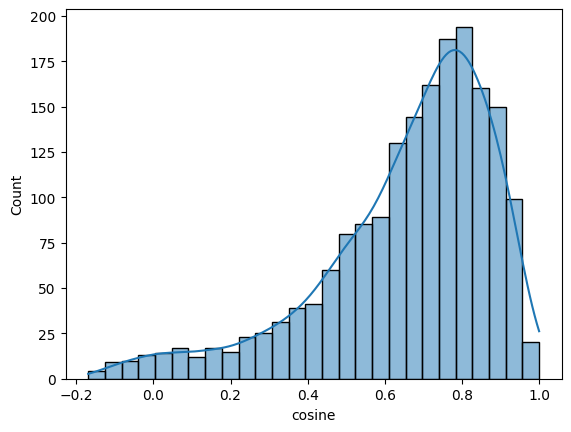

In [137]:
sns.histplot(df_chat_gpt_35_turbo["cosine"], kde=True)

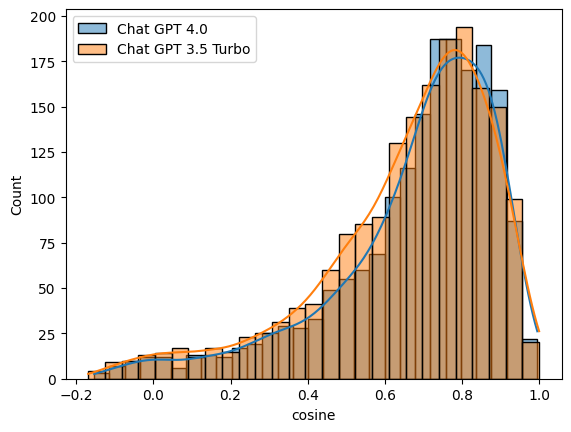

In [142]:
import matplotlib.pyplot as plt

sns.histplot(df_chat_gpt_4o["cosine"], kde=True, label="Chat GPT 4.0")
sns.histplot(df_chat_gpt_35_turbo["cosine"], kde=True, label="Chat GPT 3.5 Turbo")

plt.legend()

## LLM as a judge

In [148]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [154]:
df_sample = df_chat_gpt_35_turbo.sample(n=20, random_state=1)

In [171]:
df_sample

,answer_llm,answer_orig,document,question,course,cosine
726,The syntax for using precision_recall_fscore_s...,Scikit-learn offers another way: precision_rec...,403bbdd8,What is the syntax for using precision_recall_...,machine-learning-zoomcamp,0.919155
1662,"Based on the provided FAQ context, to avoid pi...",When running a docker container with waitress ...,236864c2,How should I modify my scripts to avoid pickle...,machine-learning-zoomcamp,0.688968
834,The command that launches a container image in...,Launch the container image in interactive mode...,63a81b57,What command launches a container image in int...,machine-learning-zoomcamp,0.850292
1234,"Yes, you can feel free to make a pull request ...",Pytorch is also a deep learning framework that...,c4ff26e5,Can we make a pull request for homework soluti...,machine-learning-zoomcamp,0.441264
1323,The cause of the pip version error in this wee...,When running docker build -t dino-dragon-model...,42c09143,What might be the cause of the pip version err...,machine-learning-zoomcamp,0.334170
1461,"After editing the metrics-server, you should r...",In case the HPA instance does not run correctl...,df023a13,What command do we run after editing the metri...,machine-learning-zoomcamp,0.815723
1529,To check your AWS CLI version for eksctl compa...,Make sure you are on AWS CLI v2 (check with aw...,00882c83,How can I check my AWS CLI version for eksctl ...,machine-learning-zoomcamp,0.504434
698,One main reason for different accuracy values ...,"One main reason behind that, is the way of spl...",25481ce5,What is one main reason for different accuracy...,machine-learning-zoomcamp,0.540440
1289,If you lose the REMOTE_URI variable after the ...,"Solution description\nIn the unit 9.6, Alexey ...",60fa95ed,What should I do if I lose the REMOTE_URI vari...,machine-learning-zoomcamp,0.789720
1751,"I'm sorry, but I cannot find any information r...",The image dataset for the competition was in a...,20174c95,Where can I find the script for generating the...,machine-learning-zoomcamp,0.573699


In [155]:
samples = df_sample.to_dict(orient='records')

In [157]:
pprint(samples[0:3])

[{'answer_llm': 'The syntax for using precision_recall_fscore_support in '
                'Python is:\n'
                'from sklearn.metrics import precision_recall_fscore_support\n'
                'precision, recall, fscore, support = '
                'precision_recall_fscore_support(y_val, y_val_pred, '
                'zero_division=0)',
  'answer_orig': 'Scikit-learn offers another way: '
                 'precision_recall_fscore_support\n'
                 'Example:\n'
                 'from sklearn.metrics import precision_recall_fscore_support\n'
                 'precision, recall, fscore, support = '
                 'precision_recall_fscore_support(y_val, y_val_pred, '
                 'zero_division=0)\n'
                 '(Gopakumar Gopinathan)',
  'cosine': 0.9191551208496094,
  'course': 'machine-learning-zoomcamp',
  'document': '403bbdd8',
  'question': 'What is the syntax for using precision_recall_fscore_support in '
              'Python?'},
 {'answer_llm': 'Bas

In [159]:
prompt = prompt1_template.format(**samples[0])
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: Scikit-learn offers another way: precision_recall_fscore_support
Example:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)
(Gopakumar Gopinathan)
Generated Question: What is the syntax for using precision_recall_fscore_support in Python?
Generated Answer: The syntax for using precision_recall_fscore_support in Python is:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)



In [ ]:
llm_as_judge_sample = llm(prompt)

In [161]:
pprint(llm_as_judge_sample)

('{\n'
 '  "Relevance": "RELEVANT",\n'
 '  "Explanation": "The generated answer is identical to the original answer, '
 'providing the same Python syntax for using the '
 'precision_recall_fscore_support function from the sklearn.metrics module."\n'
 '}')


In [163]:
llm_as_judge_samples = []

In [166]:
for sample in tqdm(samples):
    prompt = prompt1_template.format(**sample)
    llm_as_judge_samples.append(llm(prompt))

100%|██████████| 20/20 [00:41<00:00,  2.09s/it]


In [167]:
pprint(llm_as_judge_samples[1])

('{\n'
 '  "Relevance": "RELEVANT",\n'
 '  "Explanation": "The generated answer is the same as the original answer, '
 'providing the correct syntax for using the precision_recall_fscore_support '
 'function in Python with the same example."\n'
 '}')


In [170]:
samples[0]

{'answer_llm': 'The syntax for using precision_recall_fscore_support in Python is:\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)',
 'answer_orig': 'Scikit-learn offers another way: precision_recall_fscore_support\nExample:\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n(Gopakumar Gopinathan)',
 'document': '403bbdd8',
 'question': 'What is the syntax for using precision_recall_fscore_support in Python?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.9191551208496094}

In [177]:
df = pd.DataFrame(llm_as_judge_samples)

In [178]:
df

,0
0,"{\n ""Relevance"": ""RELEVANT"",\n ""Explanation""..."
1,"{\n ""Relevance"": ""RELEVANT"",\n ""Explanation""..."
2,"{\n ""Relevance"": ""RELEVANT"",\n ""Explanation""..."
3,"{\n ""Relevance"": ""RELEVANT"",\n ""Explanation""..."
4,"{\n ""Relevance"": ""RELEVANT"",\n ""Explanation""..."
5,"{\n ""Relevance"": ""PARTLY_RELEVANT"",\n ""Expla..."
6,"{\n ""Relevance"": ""RELEVANT"",\n ""Explanation""..."
7,"{\n ""Relevance"": ""RELEVANT"",\n ""Explanation""..."
8,"{\n ""Relevance"": ""PARTLY_RELEVANT"",\n ""Expla..."
9,"{\n ""Relevance"": ""RELEVANT"",\n ""Explanation""..."


In [179]:
file_output_llm_as_judge = "/workspaces/llm-zoomcamp/04-monitoring/llm_as_a_judge.csv"

df.to_csv(file_output_llm_as_judge)

In [186]:
llm_as_judge_samples[3]

'{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer is identical to the original answer, with no additional information or context. Thus, the relevance is high."\n}'

In [189]:
answers_jsons = []

In [190]:
import json

for answer in llm_as_judge_samples:
    answer_as_json = json.loads(answer)
    answers_jsons.append(answer_as_json)

In [193]:
answers_jsons[0:2]

[{'Relevance': 'RELEVANT',
  'Explanation': 'The generated answer is identical to the original answer and provides a precise explanation of the syntax required to use the `precision_recall_fscore_support` function in Python.'},
 {'Relevance': 'RELEVANT',
  'Explanation': 'The generated answer is the same as the original answer, providing the correct syntax for using the precision_recall_fscore_support function in Python with the same example.'}]

In [194]:
df_answers = pd.DataFrame(answers_jsons)

In [195]:
df_answers

,Relevance,Explanation
0,RELEVANT,The generated answer is identical to the origi...
1,RELEVANT,The generated answer is the same as the origin...
2,RELEVANT,The generated answer provides the same solutio...
3,RELEVANT,The generated answer is identical to the origi...
4,RELEVANT,The generated answer accurately conveys the sa...
5,PARTLY_RELEVANT,The generated answer addresses a potential ver...
6,RELEVANT,The generated answer is identical to the origi...
7,RELEVANT,The generated answer is relevant as it matches...
8,PARTLY_RELEVANT,The generated answer correctly identifies the ...
9,RELEVANT,The generated answer accurately and directly a...


In [199]:
df_answers.Relevance.value_counts()

Relevance
RELEVANT           16
PARTLY_RELEVANT     3
NON_RELEVANT        2
Name: count, dtype: int64

Let's take a look at `NON_RELEVANT` answers.

In [231]:
df_answers[df_answers.Relevance == "NON_RELEVANT"]

,Relevance,Explanation
10,NON_RELEVANT,The generated answer did not find the requeste...
12,NON_RELEVANT,The generated answer focuses on addressing a p...


In [235]:
df_answers[df_answers.Relevance == "NON_RELEVANT"].to_dict()

{'Relevance': {10: 'NON_RELEVANT', 12: 'NON_RELEVANT'},
 'Explanation': {10: 'The generated answer did not find the requested information, whereas the original answer not only provided the link to the script but also explained the context behind it.',
  12: "The generated answer focuses on addressing a protobuf package issue, whereas the original answer relates to a different problem with the 'eb local' command and Docker platform compatibility."}}

In [234]:
pprint(samples[10])

{'answer_llm': 'The solution for the TensorFlow Serving error on Apple M1 Mac '
               'is to use the command `docker pull '
               'emacski/tensorflow-serving:latest` and then run it with '
               '`docker run -it --rm -p 8500:8500 -v '
               '$(pwd)/clothing-model:/models/clothing-model/1 -e '
               'MODEL_NAME="clothing-model" '
               'emacski/tensorflow-serving:latest-linux_arm64`. More '
               'information can be found on the GitHub page: '
               'https://github.com/emacski/tensorflow-serving-arm.',
 'answer_orig': 'While trying to run the docker code on M1:\n'
                'docker run --platform linux/amd64 -it --rm \\\n'
                '-p 8500:8500 \\\n'
                '-v $(pwd)/clothing-model:/models/clothing-model/1 \\\n'
                '-e MODEL_NAME="clothing-model" \\\n'
                'tensorflow/serving:2.7.0\n'
                'It outputs the error:\n'
                'Error:\n'
               